# Atmospheric composition distribution by CAMS and TROPOMI

### Main goal:
* Compare TROPOMI and CAMS datasets for NO<sub>2</sub>, CO, O<sub>3</sub> and SO<sub>2</sub> (Level 2).

## Imports and supporting functions

In [332]:
import os 
from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt
import cdsapi
import cfgrib
import xarray as xr
import pandas as pd
import numpy as np
from itertools import product
import scipy.interpolate
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import math
import geojson
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist

In [365]:
%run functions/functions_general.ipynb
%run functions/functions_cams.ipynb
%run functions/functions_tropomi.ipynb

In [334]:
# Hide pandas warning
pd.options.mode.chained_assignment = None

## 1. Define datasets

In [335]:
model = 'cams'
model_full_name = 'cams-global-atmospheric-composition-forecasts'
sensor = 'tropomi'
component_nom = 'O3'
    
# Check if comparison is possible
comparison_check(sensor, model, component_nom, model_full_name)

# Get component full name and molecular weight
component, component_mol_weight, product_type, sensor_column = components_table(sensor, component_nom)

# Folders generation
generate_folders(model, sensor, component_nom)

The comparison is possible and will start now.


In [336]:
# Define latitudes and longitudes
lat_min = 48.5
lat_max = 51.1
lon_min = 12
lon_max = 18.9

# Create bbox
bbox = ((lon_min, lat_min), (lon_max, lat_max))

# Define search period
print('SEARCH PERIOD')

# TROPOMI
dates = ('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z',
        '2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')
period = pairwise(dates)
start_date = dates[0].split('T')[0]
end_date = dates[-1].split('T')[0]
print(f'- In hours: {period}')

SEARCH PERIOD
- In hours: [('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z'), ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')]


## 2. Model data

### Download, read and subset data as xarray

In [337]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, 
                                               component_nom, model_full_name, model_level = 'Multiple')
model_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_ds = subset(model_ds, bbox)
model_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (hybrid: 137, latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 ... 134.0 135.0 136.0 137.0
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, hybrid, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-09T22:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Collect 137 levels model data

In [338]:
model_levels_df = CAMS_137_levels()
model_levels_df

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3],ph [Pa],ph-diff [Pa],Depth [m]
hybrid,,,,,,,,,,,
1,2.000365,0.000000,0.0200,0.0100,79301.79,80301.65,198.05,0.000018,2.00,2.00,5580.21
2,3.102241,0.000000,0.0310,0.0255,73721.58,74584.91,209.21,0.000042,3.10,1.10,2605.83
3,4.666084,0.000000,0.0467,0.0388,71115.75,71918.79,214.42,0.000063,4.67,1.57,2497.32
4,6.827977,0.000000,0.0683,0.0575,68618.43,69365.77,221.32,0.000090,6.83,2.16,2407.44
5,9.746966,0.000000,0.0975,0.0829,66210.99,66906.53,228.06,0.000127,9.75,2.92,2320.96
...,...,...,...,...,...,...,...,...,...,...,...
133,62.781250,0.988500,1002.2250,1000.5165,106.54,106.54,287.46,1.212498,100222.50,341.69,27.50
134,22.835938,0.991984,1005.3562,1003.7906,79.04,79.04,287.64,1.215710,100535.62,313.12,25.12
135,3.757813,0.995003,1008.2239,1006.7900,53.92,53.92,287.80,1.218650,100822.39,286.77,22.96


### Convert CAMS data units (kg/kg to molecules/cm<sup>2</sup>)

In [339]:
model_ds = model_convert_units(model_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg kg**-1 to kg m**-2.
The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


### Download, read and subset total columns data

In [340]:
model_product_name, model_type = CAMS_download(dates, start_date, end_date, component, component_nom, 
                                               model_full_name, model_level = 'Single')
model_total_ds, _ = CAMS_read(model_product_name, component, component_nom, dates)
model_total_ds = subset(model_total_ds, bbox)
model_total_ds

The file exists, it will not be downloaded again.


<xarray.Dataset>
Dimensions:     (latitude: 8, longitude: 18, step: 4, time: 2)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2021-08-21 2021-08-22
  * step        (step) timedelta64[ns] 00:00:00 06:00:00 12:00:00 18:00:00
    surface     float64 ...
  * latitude    (latitude) float64 48.4 48.8 49.2 49.6 50.0 50.4 50.8 51.2
  * longitude   (longitude) float64 12.0 12.4 12.8 13.2 ... 17.6 18.0 18.4 18.8
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    component   (time, step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-09-09T22:31 GRIB to CDM+CF via cfgrib-0.9.9...

### Convert CAMS total columns data units (kg/m2 to molecules/cm<sup>2</sup>)

In [341]:
model_total_ds = model_convert_units(model_total_ds, model, component_mol_weight, component, conversion_method = 'Simple')

The model component units have been converted from kg m**-2 to molec cm-2.
The model component units have been converted from molec cm-2 to DU.


## 3. Sensor data

### Collect and read data as xarray

In [342]:
sensor_product_names = []

for i in range(0, len(period)):
    
    input_type = 'Query'
    processing_mode = 'Near real time' # Offline, Near real time, Reprocessing
    file_name, sensor_product_name = TROPOMI_download(input_type, bbox, period[i], product_type, processing_mode, component_nom)
    sensor_product_names.append(sensor_product_name)

You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-09 22:31:38,179 INFO Found 1 products


RESULTS FOR PERIOD ('2021-08-21T00:00:00Z', '2021-08-21T23:00:00Z')
Number 0: S5P_NRTI_L2__O3_____20210821T115635_20210821T120135_19977_02_020201_20210821T130019
SELECTED
File name: 3354b86b-3a78-40b8-9d87-2921cd682483
Product name: S5P_NRTI_L2__O3_____20210821T115635_20210821T120135_19977_02_020201_20210821T130019.nc
The file exists, it will not be downloaded again.
You can see all the results at https://s5phub.copernicus.eu/dhus/.


2021-09-09 22:31:48,034 INFO Found 1 products


RESULTS FOR PERIOD ('2021-08-22T00:00:00Z', '2021-08-22T23:00:00Z')
Number 0: S5P_NRTI_L2__O3_____20210822T113635_20210822T114135_19991_02_020201_20210822T124044
SELECTED
File name: 6f3f2fba-1075-44fb-9bd7-218de6a898d5
Product name: S5P_NRTI_L2__O3_____20210822T113635_20210822T114135_19991_02_020201_20210822T124044.nc
The file exists, it will not be downloaded again.


In [343]:
sensor_ds, support_input_ds, support_details_ds, sensor_type = TROPOMI_read(sensor_product_names, component_nom)
sensor_ds

<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 2)
Coordinates:
  * time                                   (time) datetime64[ns] 2021-08-21 2...
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [344]:
support_input_ds

<xarray.Dataset>
Dimensions:                              (ground_pixel: 450, scanline: 357, time: 2)
Coordinates:
  * time                                 (time) datetime64[ns] 2021-08-21 202...
  * scanline                             (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                         (ground_pixel) float64 0.0 ... 449.0
Data variables: (12/32)
    surface_altitude                     (time, scanline, ground_pixel) float32 ...
    surface_altitude_precision           (time, scanline, ground_pixel) float32 ...
    surface_classification               (time, scanline, ground_pixel) float32 ...
    instrument_configuration_identifier  (time, scanline) float64 nan ... nan
    instrument_configuration_version     (time, scanline) float32 nan ... nan
    scaled_small_pixel_variance          (time, scanline, ground_pixel) float32 ...
    ...                                   ...
    surface_albedo                       (time, scanline, ground_pixel) float32 ...
    effective_scene_height               (time, scanline, ground_pixel) float32 ...
    effective_scene_height_precision     (time, scanline, ground_pixel) float32 ...
    effective_scene_pressure             (time, scanline, ground_pixel) float32 ...
    effective_scene_pressure_precision   (time, scanline, ground_pixel) float32 ...
    cloud_fraction_apriori               (time, scanline, ground_pixel) float32 ...

In [345]:
support_details_ds

<xarray.Dataset>
Dimensions:                                 (ground_pixel: 450, layer: 13, level: 14, number_of_doas_polynomial_coefficients: 4, number_of_slant_columns: 4, scanline: 357, time: 2)
Coordinates:
  * time                                    (time) datetime64[ns] 2021-08-21 ...
  * scanline                                (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                            (ground_pixel) float64 0.0 ... 449.0
  * number_of_slant_columns                 (number_of_slant_columns) int32 0...
  * number_of_doas_polynomial_coefficients  (number_of_doas_polynomial_coefficients) int32 ...
Dimensions without coordinates: layer, level
Data variables: (12/25)
    ozone_profile_apriori                   (time, scanline, ground_pixel, layer) float32 ...
    averaging_kernel                        (time, scanline, ground_pixel, layer) float32 ...
    pressure_grid                           (time, scanline, ground_pixel, level) float32 ...
    fitted_slant_columns                    (time, scanline, ground_pixel, number_of_slant_columns) float64 ...
    fitted_slant_columns_precision          (time, scanline, ground_pixel, number_of_slant_columns) float32 ...
    number_of_iterations_slant_column       (time, scanline, ground_pixel) float32 ...
    ...                                      ...
    number_of_iterations_vertical_column    (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo                  (time, scanline, ground_pixel) float32 ...
    effective_scene_albedo_precision        (time, scanline, ground_pixel) float32 ...
    doas_polynomial_coefficients            (time, scanline, ground_pixel, number_of_doas_polynomial_coefficients) float32 ...
    euv                                     (time, scanline, ground_pixel) float32 ...
    processing_quality_flags                (time, scanline, ground_pixel) float64 ...

### Calculate level pressures, column kernels and apriori profiles

In [346]:
sensor_ds = TROPOMI_pressure(sensor_ds, component_nom, support_input_ds, support_details_ds)
sensor_ds = TROPOMI_column_kernel(sensor_ds, component_nom, support_details_ds)
sensor_ds = TROPOMI_apriori_profile(sensor_ds, component, support_details_ds)
sensor_ds

The layers pressures will be retrieved (unknown bound, half?).


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 2)
Coordinates:
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * time                                   (time) datetime64[ns] 2021-08-21 2...
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...
    column_kernel                          (time, scanline, ground_pixel, layer) float32 ...
    apriori_profile                        (time, scanline, ground_pixel, layer) float32 ...

### Convert TROPOMI data units (From mol/m<sup>2</sup> to molecules/cm<sup>2</sup>)

In [347]:
sensor_ds = sensor_convert_units(sensor_ds, sensor_column, sensor, component)
sensor_ds

The sensor component units have been converted from mol cm-2 to molec cm-2.
The sensor component units have been converted from molec cm-2 to DU.


<xarray.Dataset>
Dimensions:                                (corner: 4, ground_pixel: 450, layer: 13, level: 14, scanline: 357, time: 2)
Coordinates:
  * layer                                  (layer) int32 0 1 2 3 ... 9 10 11 12
  * level                                  (level) int32 0 1 2 3 ... 10 11 12 13
  * time                                   (time) datetime64[ns] 2021-08-21 2...
  * scanline                               (scanline) float64 0.0 1.0 ... 356.0
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object nan ... nan
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float64 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...
    pressure                               (time, scanline, ground_pixel, level) float32 ...
    column_kernel                          (time, scanline, ground_pixel, layer) float32 ...
    apriori_profile                        (time, scanline, ground_pixel, layer) float64 ...

## 4. Match data (and apply averaging kernels)

In [351]:
kernels_method = None # None, Interpolation or Nearest neighbours
match_table = generate_match_table(sensor_ds, model_ds, bbox, kernels_method, 
                                   sensor, component_nom, sensor_column, model_levels_df)
match_table

FOR EST. TIME: 2021-08-21T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.
FOR EST. TIME: 2021-08-22T00:00:00.000000000
The dataset does not contain data to apply the averaging kernels.
The partial columns will be sumed up.
The sum will be matched to the sensor data by nearest neighbours.


delta_time   latitude  \
scanline ground_pixel time       layer                                      
159.0    210.0        2021-08-21 0     2021-08-21 11:58:49.210  47.614220   
         211.0        2021-08-21 0     2021-08-21 11:58:49.210  47.623692   
         212.0        2021-08-21 0     2021-08-21 11:58:49.210  47.633114   
         213.0        2021-08-21 0     2021-08-21 11:58:49.210  47.642490   
         214.0        2021-08-21 0     2021-08-21 11:58:49.210  47.651817   
...                                                        ...        ...   
316.0    267.0        2021-08-22 12    2021-08-22 11:41:00.645  52.308792   
         268.0        2021-08-22 12    2021-08-22 11:41:00.645  52.316521   
         269.0        2021-08-22 12    2021-08-22 11:41:00.645  52.324215   
         270.0        2021-08-22 12    2021-08-22 11:41:00.645  52.331879   
         271.0        2021-08-22 12    2021-08-22 11:41:00.645  52.339504   

                                        longitude  qa_value  \
scanline ground_pixel time       layer                        
159.0    210.0        2021-08-21 0      12.400393       1.0   
         211.0        2021-08-21 0      12.446805       1.0   
         212.0        2021-08-21 0      12.493213       0.8   
         213.0        2021-08-21 0      12.539617       1.0   
         214.0        2021-08-21 0      12.586020       1.0   
...                                           ...       ...   
316.0    267.0        2021-08-22 12     18.153767       1.0   
         268.0        2021-08-22 12     18.207802       0.9   
         269.0        2021-08-22 12     18.261974       0.9   
         270.0        2021-08-22 12     18.316290       0.9   
         271.0        2021-08-22 12     18.370750       0.9   

                                        ozone_total_vertical_column  \
scanline ground_pixel time       layer                                
159.0    210.0        2021-08-21 0                       308.106845   
         211.0        2021-08-21 0                       304.590348   
         212.0        2021-08-21 0                       308.290955   
         213.0        2021-08-21 0                       305.371103   
         214.0        2021-08-21 0                       308.865442   
...                                                             ...   
316.0    267.0        2021-08-22 12                      310.856060   
         268.0        2021-08-22 12                      311.246260   
         269.0        2021-08-22 12                      312.437555   
         270.0        2021-08-22 12                      314.565529   
         271.0        2021-08-22 12                      309.693680   

                                        ozone_total_vertical_column_precision  \
scanline ground_pixel time       layer                                          
159.0    210.0        2021-08-21 0                                   0.001886   
         211.0        2021-08-21 0                                   0.002109   
         212.0        2021-08-21 0                                   0.002027   
         213.0        2021-08-21 0                                   0.002412   
         214.0        2021-08-21 0                                   0.002296   
...                                                                       ...   
316.0    267.0        2021-08-22 12                                  0.001706   
         268.0        2021-08-22 12                                  0.001759   
         269.0        2021-08-22 12                                  0.002109   
         270.0        2021-08-22 12                                  0.002389   
         271.0        2021-08-22 12                                  0.001817   

                                            pressure  column_kernel  \
scanline ground_pixel time       layer                                
159.0    210.0        2021-08-21 0      13672.228516       0.876253   
         211.0        2021-08-21 0     

## 5. Merge data and calculate difference

In [352]:
merge_table = generate_merge_table(match_table, sensor_ds, model_ds, kernels_method, sensor_column, sensor)
merge_table

latitude  longitude  model_column  \
scanline ground_pixel time                                             
159.0    210.0        2021-08-21  47.614216  12.400393    305.422790   
         211.0        2021-08-21  47.623695  12.446806    305.422790   
         212.0        2021-08-21  47.633114  12.493212    305.422790   
         213.0        2021-08-21  47.642494  12.539617    305.422790   
         214.0        2021-08-21  47.651814  12.586019    305.422790   
...                                     ...        ...           ...   
316.0    267.0        2021-08-22  52.308784  18.153765    307.141873   
         268.0        2021-08-22  52.316525  18.207798    306.584041   
         269.0        2021-08-22  52.324215  18.261976    306.584041   
         270.0        2021-08-22  52.331882  18.316288    306.584041   
         271.0        2021-08-22  52.339497  18.370754    306.584041   

                                  ozone_total_vertical_column  difference  
scanline ground_pixel time                                                 
159.0    210.0        2021-08-21                   308.106845    2.684055  
         211.0        2021-08-21                   304.590348   -0.832441  
         212.0        2021-08-21                   308.290955    2.868165  
         213.0        2021-08-21                   305.371103   -0.051687  
         214.0        2021-08-21                   308.865442    3.442652  
...                                                       ...         ...  
316.0    267.0        2021-08-22                   310.856060    3.714186  
         268.0        2021-08-22                   311.246260    4.662218  
         269.0        2021-08-22                   312.437555    5.853514  
         270.0        2021-08-22                   314.565529    7.981488  
         271.0        2021-08-22                   309.693680    3.109639  

[20268 rows x 5 columns]

## 6. Show comparison plots

### Select plot dates

In [353]:
plot_dates = plot_period(sensor_ds, sensor)

The plots will be shown for the following dates:
['2021-08-21T00:00:00.000000000' '2021-08-22T00:00:00.000000000']


### Select plot extent

In [354]:
plot_bbox = plot_extent(bbox)

The plots will be shown for the following spatial extent: 
((12, 48.5), (18.9, 51.1))


### Compare CAMS and TROPOMI total columns

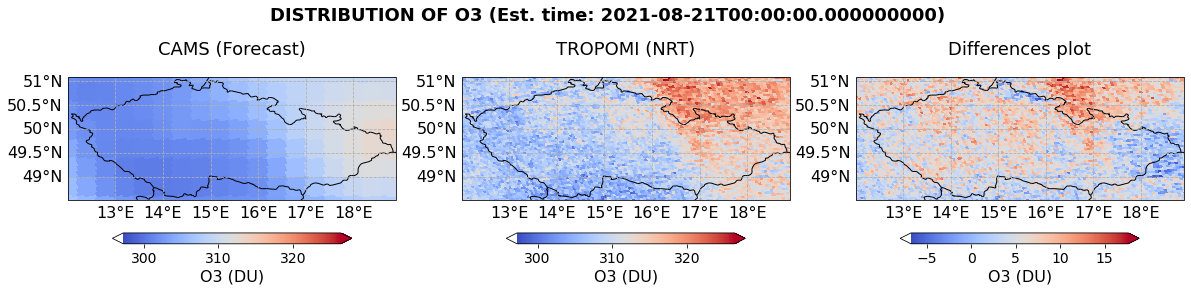

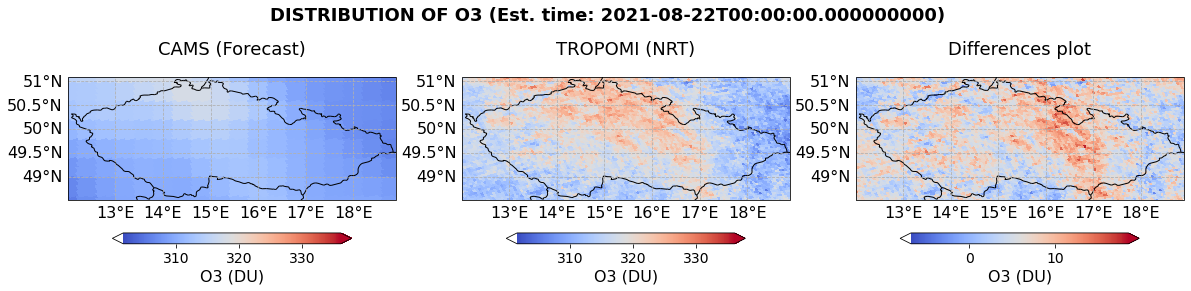

In [359]:
range_type = 'Equal' # Original, Positive, Equal
visualize_model_vs_sensor(model, sensor, component_nom, model_ds, merge_table, plot_dates, 
                          plot_bbox, 20, 0.95, model_type, sensor_type, range_type)

### Compare CAMS original and averaged total columns

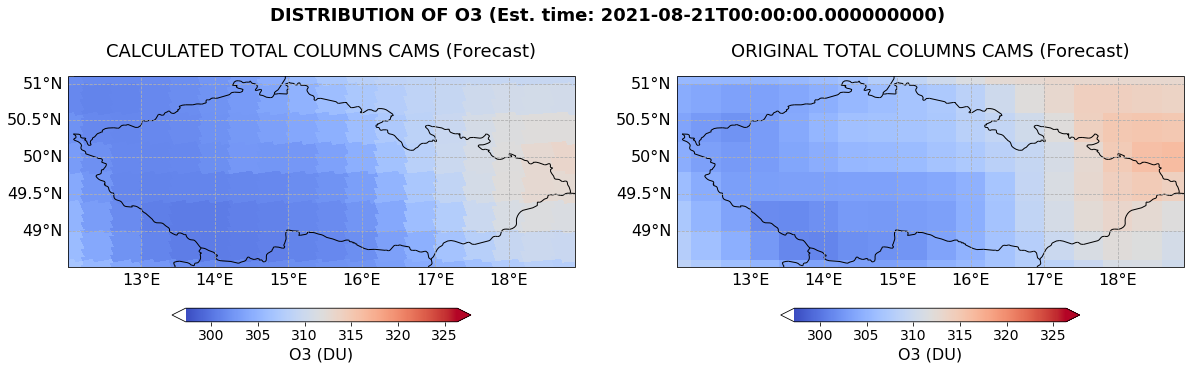

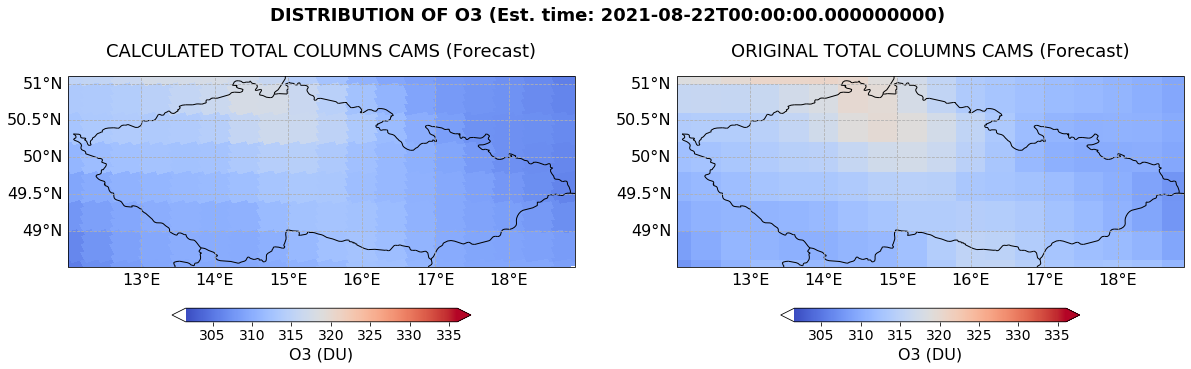

In [356]:
range_type = 'Equal' # Original, Positive, Equal
visualize_model_original_vs_calculated(model, component_nom, model_ds, merge_table, model_total_ds, plot_dates, 
                                       plot_bbox, 20, 1, model_type, range_type)

## 7. Scatter plots

Est. time: 2021-08-21T00:00:00.000000000
Fit equation: O3_model = O3_sensor * 0.58 + (1.24E+02)
Coefficient of determination (R2): 0.55


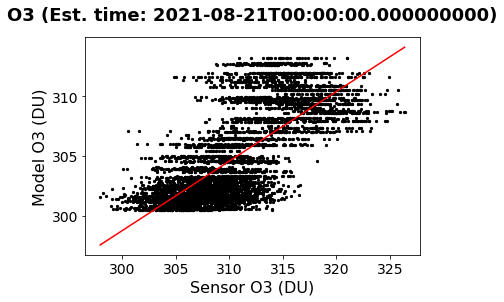

Est. time: 2021-08-22T00:00:00.000000000
Fit equation: O3_model = O3_sensor * 0.47 + (1.63E+02)
Coefficient of determination (R2): 0.51


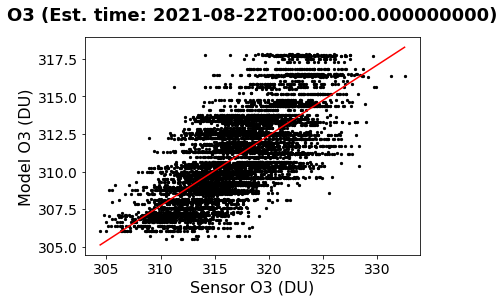

In [357]:
scatter_plot(merge_table.dropna(), component_nom, model_ds, sensor_column, sensor, plot_dates, plot_bbox, 1.05)

## 8. Retrieve nearest values to specific latitude and longitude

In [366]:
coords_search_list = (50, 60,
                      4, 10,
                      20, 30)
coords_search = pairwise(coords_search_list)
retrieval_table_all =  retrieve_coords(merge_table, coords_search, component_nom, sensor_column, sensor, model)
retrieval_table_all

,,,,,scanline,ground_pixel,model_column,ozone_total_vertical_column,difference
lat_search,lon_search,latitude,longitude,time,,,,,
50,60,48.699467,19.837696,2021-08-22,241.0,271.0,308.183904,310.932172,2.748267
4,10,47.155941,12.771408,2021-08-22,241.0,127.0,308.387827,305.510897,-2.876930
20,30,48.560848,19.600430,2021-08-21,159.0,345.0,307.970899,316.813887,8.842988
